In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.data_provider_27_price_history_mobattrs_date import PriceHistoryMobAttrsDateDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.model_27_price_history_mobattrs_date import PriceHistoryMobAttrsDateModel
from gp_opt.price_history_27_gp_opt import PriceHistoryGpOpt
from datetime import datetime

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
input_len = 60
target_len = 30

batch_size = 300
with_EOS = False

In [5]:
full_train_size = 55820
train_size = 55800
small_train_size = 6000 #just because of performance reasons, no statistics behind this decision
test_size = 6200

### Once generate data

In [6]:
data_path = '../../../../Dropbox/data'

In [7]:
ph_data_path = data_path + '/price_history'

In [8]:
# npz_train_reduced = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_6000_train.npz'
# npz_train = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_train.npz'
# npz_test = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_test.npz'

In [9]:
#npz_path = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_6000'
npz_path = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed'

In [10]:
npz_train = npz_path + '_train.npz'
assert path.isfile(npz_train)
path.abspath(npz_train)

'/home/studenthp/Dropbox/data/price_history/price_history_mobattrs_date_dp_60to30_62020_trimmed_train.npz'

In [11]:
# npz_train_full = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_train.npz'
# npz_train_trimmed = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed_train.npz'

In [12]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_train_full, target_size=55800,
#                                                outpath=npz_train_trimmed, random_state=random_state)

### Step 1 - collect data

In [13]:
# dp = PriceHistoryMobAttrsDateDataProvider(npz_path=npz_path, batch_size=batch_size, with_EOS=with_EOS)
# for data in dp.datalist:
#     print data.shape

(55800, 60, 7)  
(55800, 139)  
(55800, 30)  
(55800, 30, 6)  

In [14]:
# for item in dp.next():
#     print item.shape

### Step 2 - Build model

In [15]:
model = PriceHistoryMobAttrsDateModel(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [16]:
graph = model.getGraph(batch_size=batch_size,
                       enc_num_units = 10,
                       dec_num_units = 10,
                       rnn_hidden_dim = 10,
                       mobile_attrs_dim = 10,
                       input_len=input_len,
                       target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(300, 7), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(300, 10), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

readout inputs
Tensor("decoder_rnn_layer/rnn/while/readout_input:0", shape=(300, 20), dtype=float32)

readout
Tensor("decoder_rnn_layer/rnn/while/readout:0", shape=(300, 1), dtype=float32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(300, 30), dtype=float32)

Tensor("error/SquaredDifference:0", shape=(300, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)



60
Tensor("inputs/unstack:0", shape=(100, 7), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(100, 10), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

readout inputs
Tensor("decoder_rnn_layer/rnn/while/readout_input:0", shape=(100, 20), dtype=float32)

readout
Tensor("decoder_rnn_layer/rnn/while/readout:0", shape=(100, 1), dtype=float32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(100, 30), dtype=float32)

Tensor("error/SquaredDifference:0", shape=(100, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
show_graph(graph, frame_size=(1200, 800))

## Quick test run

In [19]:
# def experiment():
#     return model.run(npz_path=ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed',
#                      rnn_hidden_dim = 300, #lets say worst case scenario
#                      mobile_attrs_dim = 300, #lets say worst case scenario
#                      epochs=2,
#                      batch_size = batch_size,
#                      enc_num_units = 600, #lets say worst case scenario
#                      dec_num_units = 600, #lets say worst case scenario
#                      input_len=input_len,
#                      target_len=target_len,
#                      learning_rate = 1e-2,
#                      preds_gather_enabled = False,
#                      decoder_first_input = PriceHistoryMobAttrsDateModel.DECODER_FIRST_INPUT.ZEROS,
#                     )
# aa = experiment()

keep_prob_rnn_out: 1.0  
lamda2: [0.0, 0.0, 0.0]  
learning_rate: 0.01  
enc_num_units: 600  
epochs: 2  
dec_num_units: 600  
keep_prob_readout: 1.0  
End Epoch 01 (453.036 secs): err(train) = 0.095174, current dec_ins_percent_usage: 1.00  
End Epoch 02 (460.136 secs): err(train) = 0.008046, current dec_ins_percent_usage: 0.00

# Cross Validating

In [20]:
def plotter(stats_list, label_text):
    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text)
    plt.show()

    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text,
                                  title='Validation Error', kk='error(valid)')
    plt.show()

In [21]:
obj = PriceHistoryGpOpt(model=model,
                          stats_npy_filename = 'bayes_opt_27_stats_dic',
                          cv_score_dict_npy_filename = 'bayes_opt_27_cv_scores_dic',
                          res_gp_filename = 'bayes_opt_27_res_gp',
                          epochs=20,
                          n_splits=3,
                          bayes_opt_dir=data_path + '/bayes_opt',
                          random_state=random_state,
                          plotter = plotter,
                          npz_path=npz_path,
                          batch_size=batch_size,
                          input_len=input_len,
                          target_len=target_len,
                         )

In [22]:
opt_res = obj.run_opt(n_random_starts=3, n_calls=20)

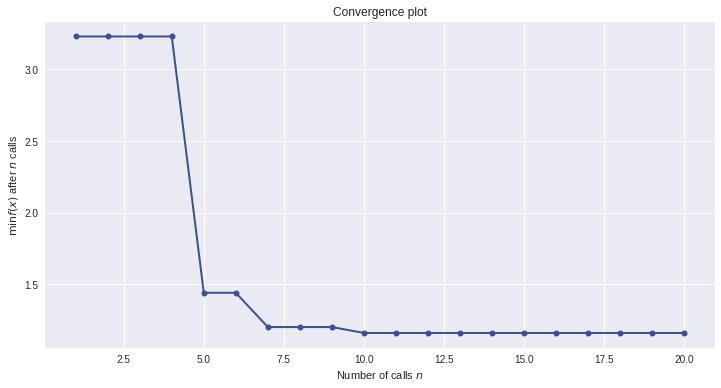

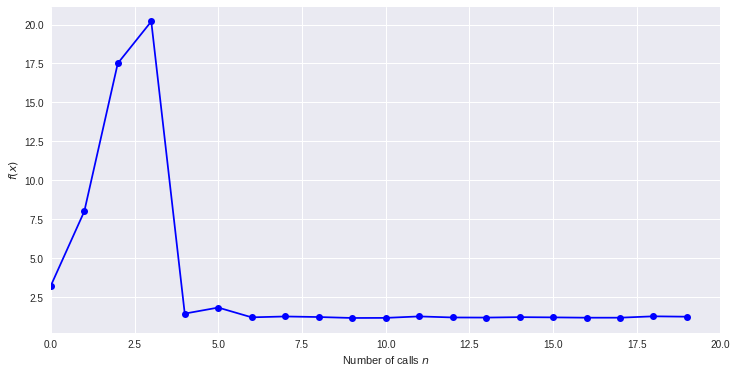

In [23]:
plot_res_gp(opt_res)

In [24]:
opt_res.best_params

[415, 1.0, 1.0, 0.01, 168, 182, 1.0, 1.0000000000000001e-05, 1.0]

In [25]:
filepath = data_path + '/bayes_opt' + '/bayes_opt_27_stats_dic.npy'
assert path.isfile(filepath)

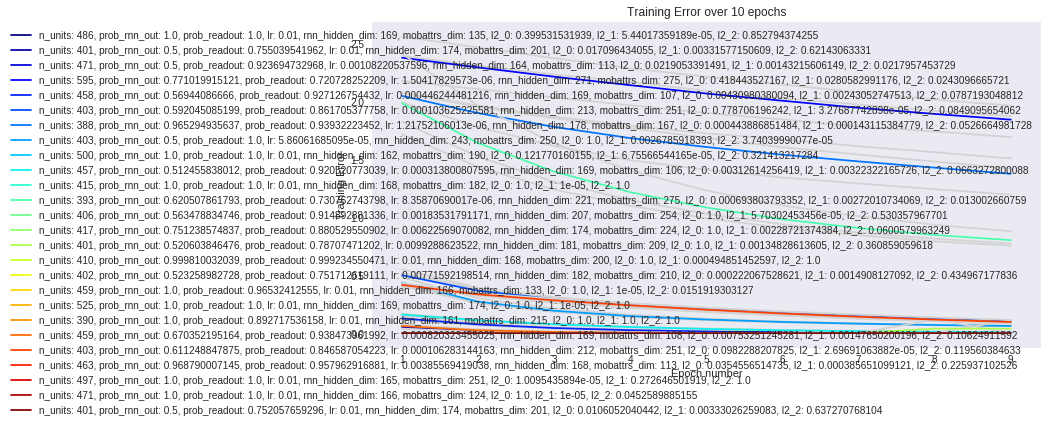

In [26]:
renderStatsCollectionOfCrossValids(stats_dic=np.load(filepath)[()], label_texts=[
    'n_units', 'prob_rnn_out', 'prob_readout', 'lr', 'rnn_hidden_dim', 'mobattrs_dim', 'l2_0', 'l2_1', 'l2_2',
])
plt.show()

### Step 3 training the network

In [27]:
model = PriceHistoryMobAttrsDateModel(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [28]:
if 'opt_res' in locals():
    print "defined above"
    best_params = opt_res.best_params
else:
    print "hardcoded"
    best_params = [415, 1.0, 1.0, 0.01, 168, 182, 1.0, 1.0000000000000001e-05, 1.0]

defined above


In [29]:
num_units, keep_prob_rnn_out, keep_prob_readout, learning_rate, rnn_hidden_dim, mobile_attrs_dim = best_params[
                                                                                :-PriceHistoryGpOpt.LAMDA2_COUNT]

In [30]:
lamda2_list = best_params[-PriceHistoryGpOpt.LAMDA2_COUNT:]

In [31]:
batch_size

300

In [32]:
npz_test = npz_path[:-len('_trimmed')] + '_test.npz'
assert path.isfile(npz_test)
path.abspath(npz_test)

'/home/studenthp/Dropbox/data/price_history/price_history_mobattrs_date_dp_60to30_62020_test.npz'

In [33]:
# npz_test_trimmed = npz_test[:-len('_test.npz')] + '_trimmed' + '_test.npz'
# npz_test_trimmed
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_test, target_size=6000,
#     outpath=npz_test_trimmed, random_state=random_state)

In [34]:
def experiment():
    return model.run(npz_path=npz_path,
             epochs=100,
             batch_size = batch_size,
             enc_num_units=num_units,
             dec_num_units=num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = learning_rate,
             batch_norm_enabled = True,
             decoder_first_input = PriceHistoryMobAttrsDateModel.DECODER_FIRST_INPUT.ZEROS,
             keep_prob_rnn_out=keep_prob_rnn_out,
             keep_prob_readout=keep_prob_readout,
             rnn_hidden_dim = rnn_hidden_dim,
             mobile_attrs_dim = mobile_attrs_dim,
             lamda2 = lamda2_list,
            )

In [35]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='027_seq2seq_60to30_000',
                                              nn_runs_folder= data_path + '/nn_runs')

keep_prob_rnn_out: 1.0
lamda2: [1.0, 1.0000000000000001e-05, 1.0]
learning_rate: 0.01
enc_num_units: 415
epochs: 100
dec_num_units: 415
keep_prob_readout: 1.0
End Epoch 01 (204.395 secs): err(train) = 0.064581, current dec_ins_percent_usage: 1.00
End Epoch 02 (203.590 secs): err(train) = 0.006825, current dec_ins_percent_usage: 0.00
End Epoch 03 (203.592 secs): err(train) = 0.006830, current dec_ins_percent_usage: 0.00
End Epoch 04 (203.483 secs): err(train) = 0.006834, current dec_ins_percent_usage: 0.00
End Epoch 05 (203.580 secs): err(train) = 0.006838, current dec_ins_percent_usage: 0.00
End Epoch 06 (203.563 secs): err(train) = 0.006840, current dec_ins_percent_usage: 0.00
End Epoch 07 (203.606 secs): err(train) = 0.006839, current dec_ins_percent_usage: 0.00
End Epoch 08 (203.559 secs): err(train) = 0.006839, current dec_ins_percent_usage: 0.00
End Epoch 09 (203.584 secs): err(train) = 0.006841, current dec_ins_percent_usage: 0.00
End Epoch 10 (203.555 secs): err(train) = 0.00684

End Epoch 93 (201.824 secs): err(train) = 0.006878, current dec_ins_percent_usage: 0.00
End Epoch 94 (201.830 secs): err(train) = 0.006869, current dec_ins_percent_usage: 0.00
End Epoch 95 (201.712 secs): err(train) = 0.006868, current dec_ins_percent_usage: 0.00
End Epoch 96 (201.716 secs): err(train) = 0.006885, current dec_ins_percent_usage: 0.00
End Epoch 97 (201.759 secs): err(train) = 0.006877, current dec_ins_percent_usage: 0.00
End Epoch 98 (201.601 secs): err(train) = 0.006869, current dec_ins_percent_usage: 0.00
End Epoch 99 (201.840 secs): err(train) = 0.006868, current dec_ins_percent_usage: 0.00
End Epoch 100 (201.671 secs): err(train) = 0.006868, current dec_ins_percent_usage: 0.00
total test error: 0.00722672904376



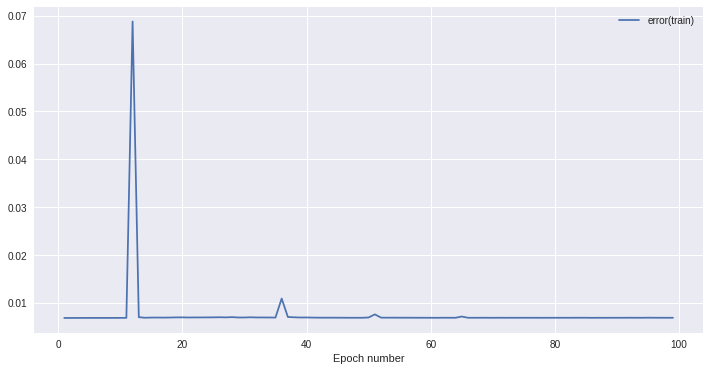

In [36]:
dyn_stats.plotStats()
plt.show()

In [38]:
from cost_functions.huber_loss import huber_loss

In [39]:
average_huber_loss = np.mean([np.mean(huber_loss(targets[ind], preds_dict[ind]))
                              for ind in range(len(targets))])
average_huber_loss

0.0036133644818469226

In [40]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [41]:
ind = np.argmin(r2_scores)
ind

5688

In [42]:
reals = targets[ind]
preds = preds_dict[ind]

In [43]:
r2_score(y_true=reals, y_pred=preds)

-3.5939910968444507e+31

In [44]:
#sns.tsplot(data=dp.inputs[ind].flatten())

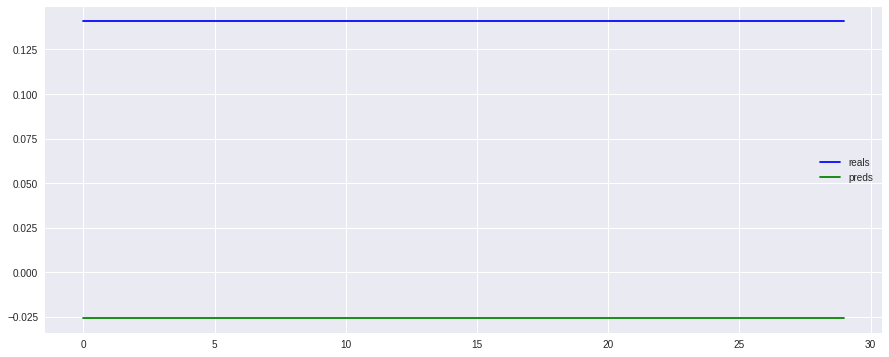

In [45]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [46]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 12.7 s, sys: 64 ms, total: 12.7 s
Wall time: 12.6 s


In [47]:
np.mean(dtw_scores)

1.2153117578330475

In [48]:
coint(preds, reals)

(0.12361515049885669,
 0.9883941185288746,
 array([-4.31395736, -3.55493606, -3.19393252]))

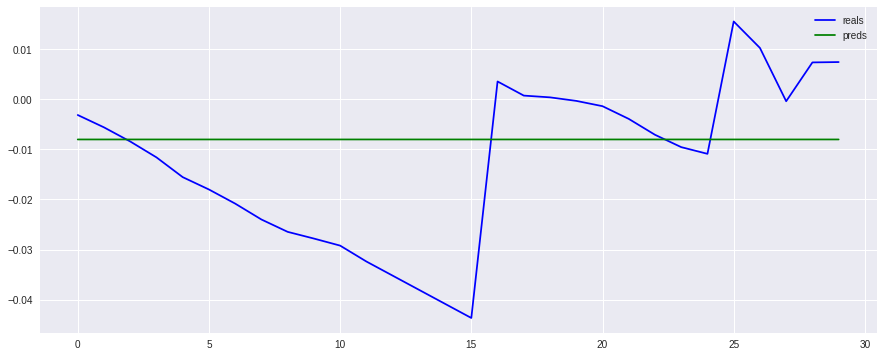

In [64]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b', label='reals')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
???